In [2]:
# Cell 1: Import necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.math import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(3)


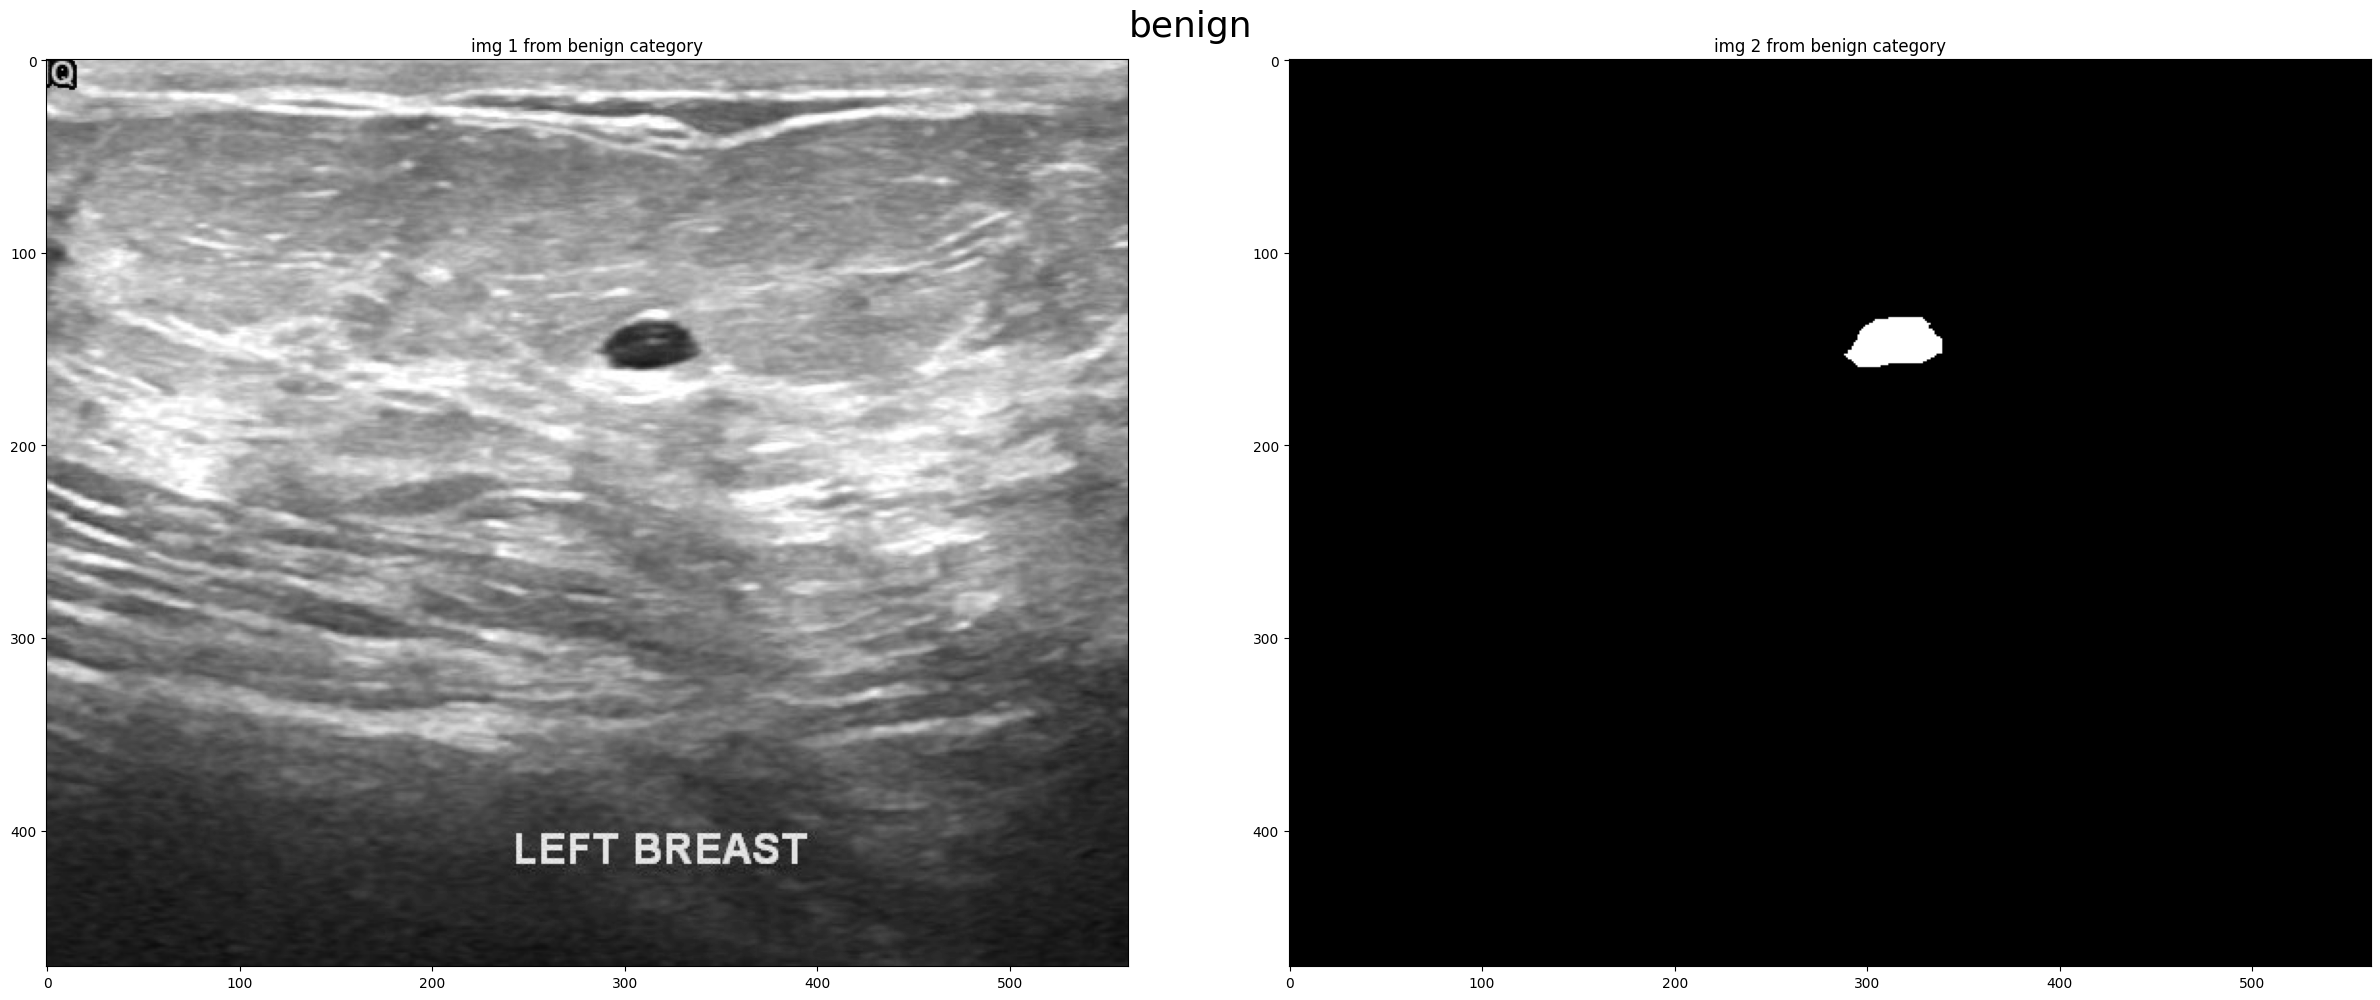

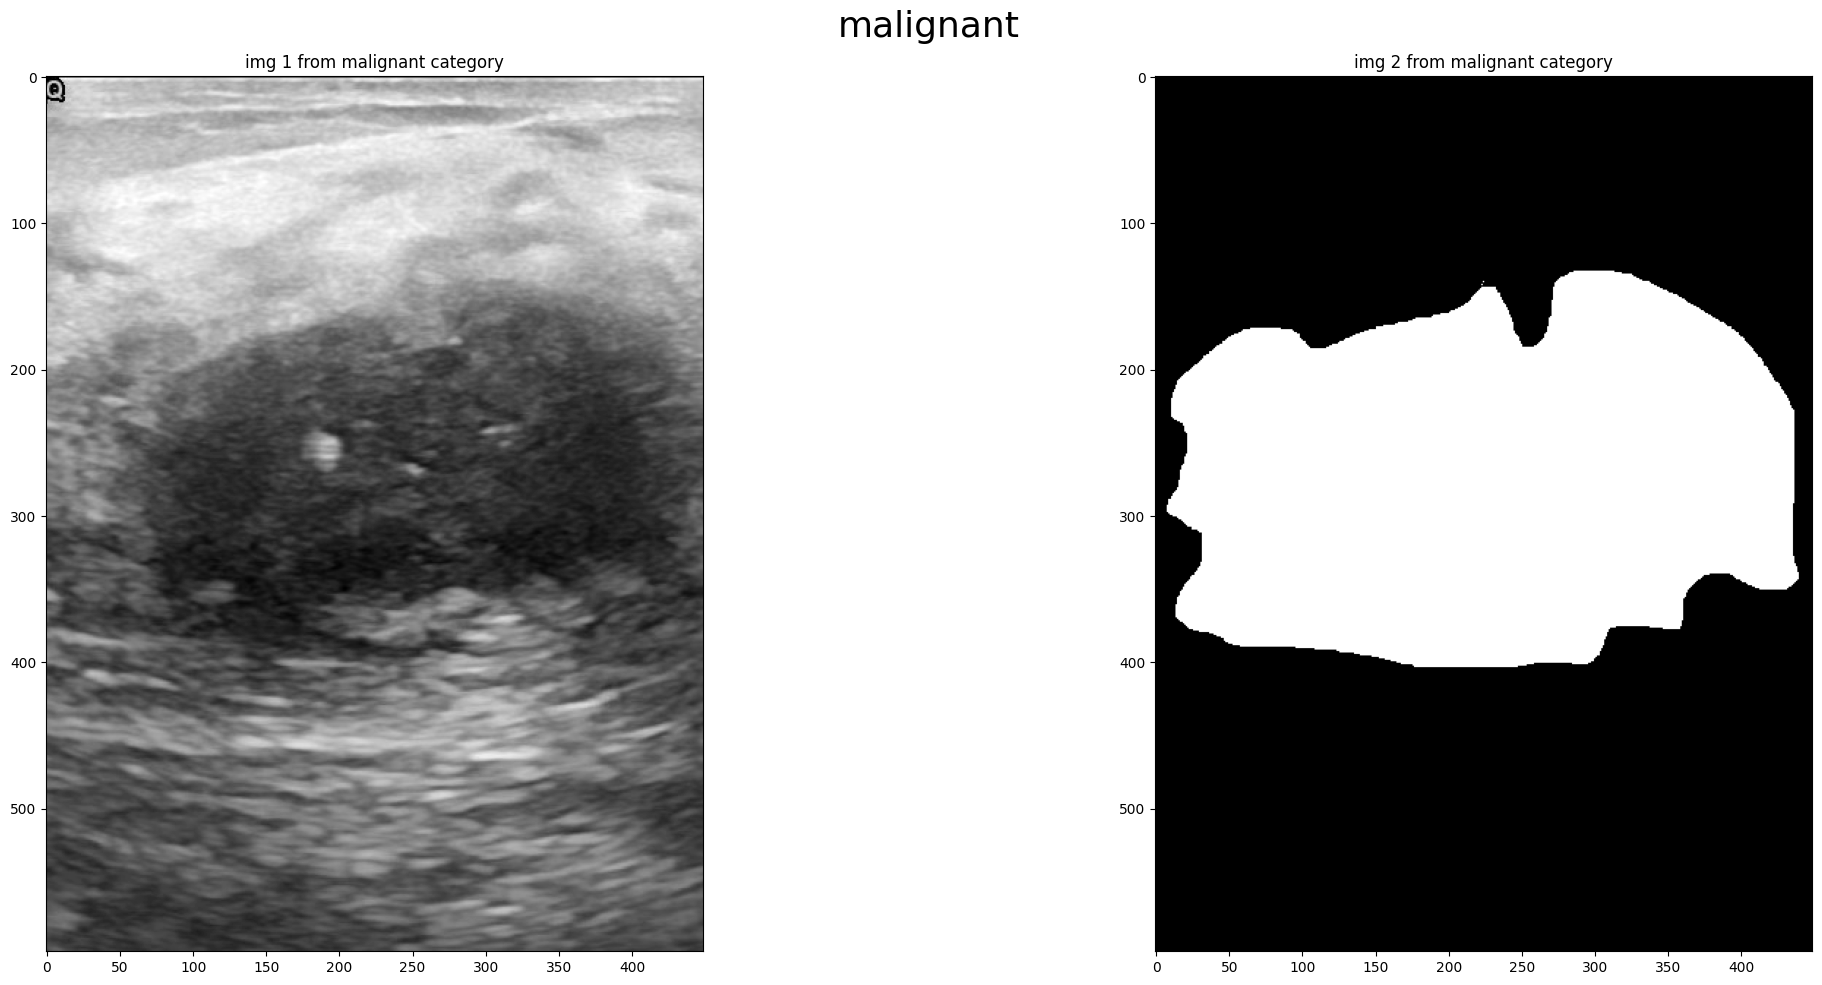

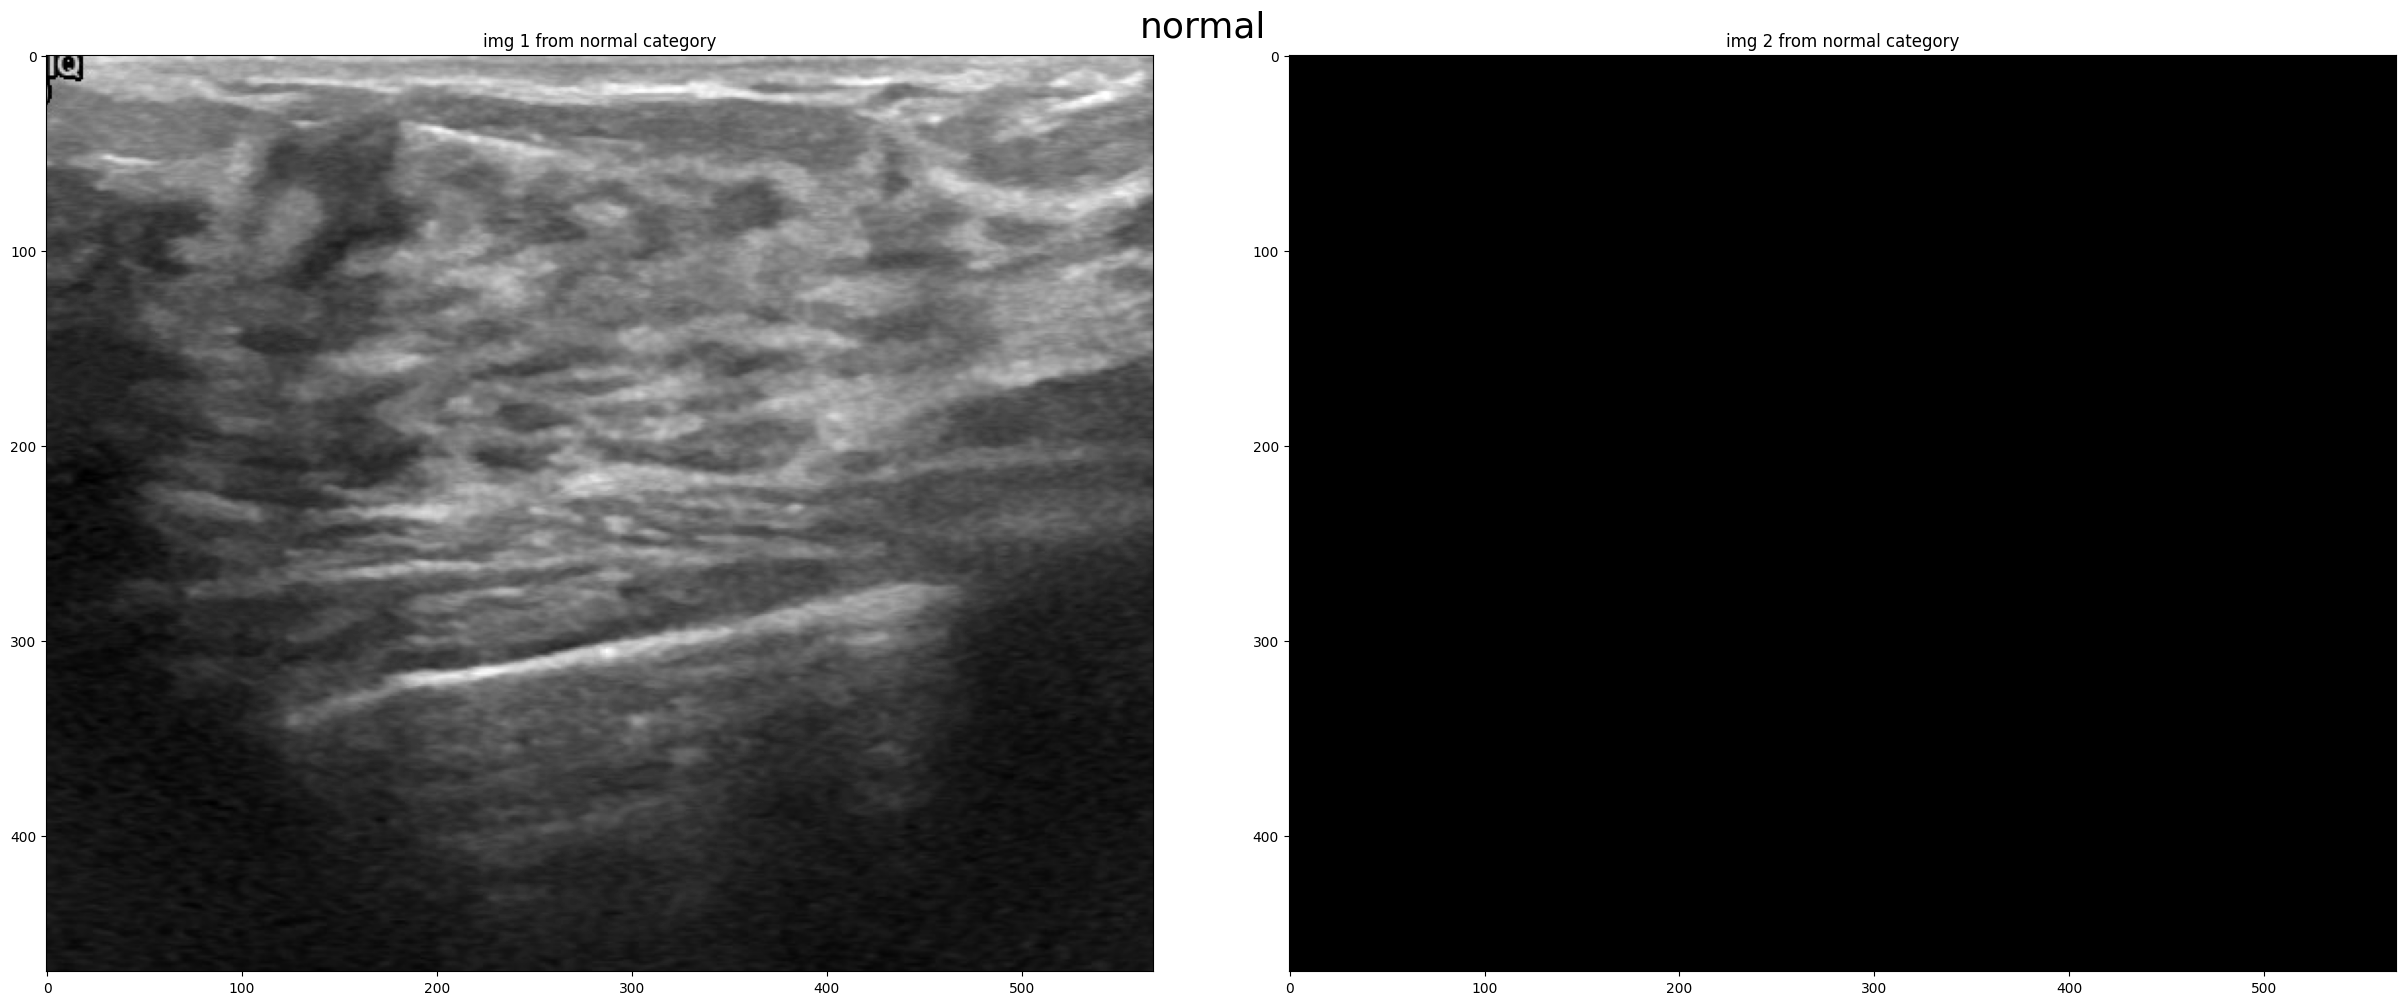

In [3]:
# Cell 2: Load and display some images from the dataset
folder_name = "C:\\Users\\Chimni\\Projects and Coding\\Version Control Systems\\Breast Cancer Detection using DL\\Dataset"
files_names = ['benign', 'malignant', 'normal']

for file in files_names:
    path = os.path.join(folder_name, file)
    x = 0
    fig, axes = plt.subplots(1, 2, figsize=(25, 10))  
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        axes[x].imshow(img_array, cmap='gray')
        axes[x].set_title(f"img {x+1} from {file} category")
        x += 1
        if x == 2: 
            break

    plt.suptitle(file, fontsize=26)
    plt.tight_layout()
    plt.show()


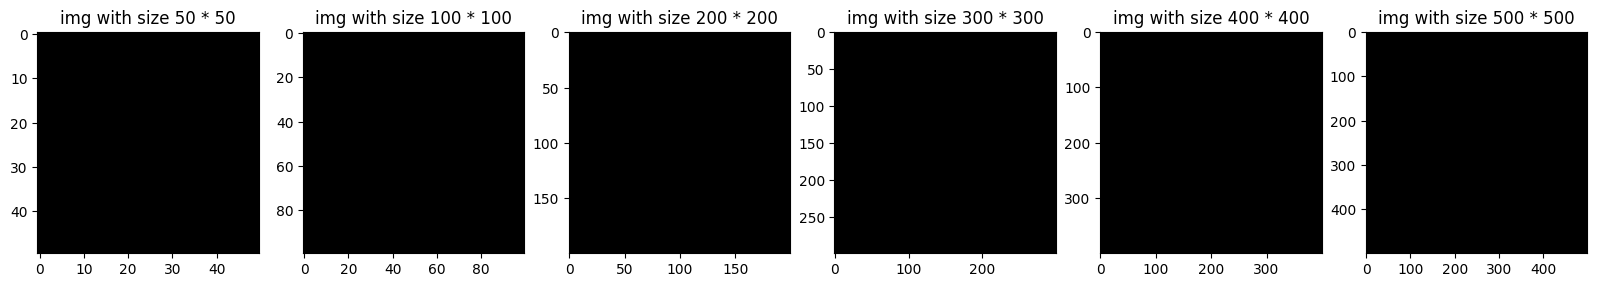

In [4]:
# Cell 3: Resize images and display examples with different sizes
img_sz = [50, 100, 200, 300, 400, 500]
plt.figure(figsize=(20, 5))

for i, sz in enumerate(img_sz):
    new_array = cv2.resize(img_array, (sz, sz))
    plt.subplot(1, len(img_sz), i+1)
    plt.imshow(new_array, cmap='gray')
    plt.title(f"img with size {sz} * {sz}")

plt.show()


In [5]:
# Cell 4: Create training data
img_sz = 300
training_data = []

def create_training_data():
    for file in files_names:
        path = os.path.join(folder_name, file)
        class_num = files_names.index(file)
        print(file, class_num)
        
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (img_sz, img_sz))  # Include resizing
            training_data.append([new_array, class_num])

create_training_data()


benign 0


100%|██████████| 891/891 [00:06<00:00, 147.13it/s]


malignant 1


100%|██████████| 421/421 [00:03<00:00, 138.89it/s]


normal 2


100%|██████████| 266/266 [00:02<00:00, 130.04it/s]


In [6]:
# Cell 5: Display class numbers for some images
for i in range(5):
    print("Class number for image", i+1, ":", training_data[i][1])

for i in range(-1, -6, -1):
    print("Class number for image", len(training_data) + i + 1, ":", training_data[i][1])


Class number for image 1 : 0
Class number for image 2 : 0
Class number for image 3 : 0
Class number for image 4 : 0
Class number for image 5 : 0
Class number for image 1578 : 2
Class number for image 1577 : 2
Class number for image 1576 : 2
Class number for image 1575 : 2
Class number for image 1574 : 2


In [7]:
# Cell 6: Shuffle the data and display the first 30 class labels after shuffling
random.shuffle(training_data)

for i in range(30):
    print(f"Sample {i+1}:")
    print("Class number:", training_data[i][1],"\n") 


Sample 1:
Class number: 0 

Sample 2:
Class number: 0 

Sample 3:
Class number: 1 

Sample 4:
Class number: 0 

Sample 5:
Class number: 0 

Sample 6:
Class number: 0 

Sample 7:
Class number: 0 

Sample 8:
Class number: 0 

Sample 9:
Class number: 2 

Sample 10:
Class number: 2 

Sample 11:
Class number: 1 

Sample 12:
Class number: 0 

Sample 13:
Class number: 0 

Sample 14:
Class number: 2 

Sample 15:
Class number: 1 

Sample 16:
Class number: 0 

Sample 17:
Class number: 2 

Sample 18:
Class number: 1 

Sample 19:
Class number: 2 

Sample 20:
Class number: 0 

Sample 21:
Class number: 0 

Sample 22:
Class number: 0 

Sample 23:
Class number: 0 

Sample 24:
Class number: 1 

Sample 25:
Class number: 1 

Sample 26:
Class number: 1 

Sample 27:
Class number: 0 

Sample 28:
Class number: 1 

Sample 29:
Class number: 2 

Sample 30:
Class number: 0 



In [8]:
# Cell 7: Prepare feature and label arrays
X = []
y = []

for feature, label in training_data:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)


(1578, 300, 300)
(1578,)


In [9]:
# Cell 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_train))
print(np.unique(y_test))


(1262, 300, 300)
(1262,)
(316, 300, 300)
(316,)
[0 1 2]
[0 1 2]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


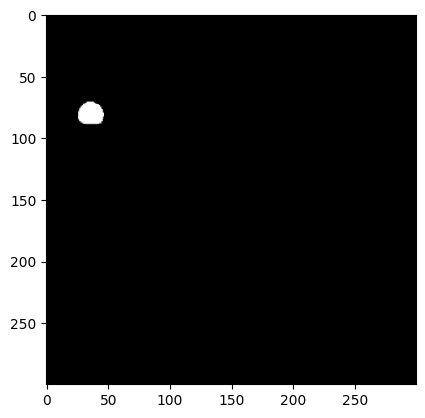

In [10]:
# Cell 9: Scale the images
X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()


In [11]:
def create_mlp_model():
    model = Sequential([
        Flatten(input_shape=(img_sz, img_sz)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(3, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_vgg16_model():
    base_model = VGG16(include_top=False, input_shape=(img_sz, img_sz, 3))
    base_model.trainable = False
    model = Sequential([
        InputLayer(input_shape=(img_sz, img_sz, 1)),
        Conv2D(3, (3, 3), padding='same'),  # Convert grayscale to RGB
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_resnet50_model():
    base_model = ResNet50(include_top=False, input_shape=(img_sz, img_sz, 3))
    base_model.trainable = False
    model = Sequential([
        InputLayer(input_shape=(img_sz, img_sz, 1)),
        Conv2D(3, (3, 3), padding='same'),  # Convert grayscale to RGB
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_model = create_mlp_model()
vgg16_model = create_vgg16_model()
resnet50_model = create_resnet50_model()

c:\Users\Chimni\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Chimni\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [12]:
# Cell 11: Train the models
history_mlp = mlp_model.fit(X_train, y_train, epochs=10, validation_split=0.1)
history_vgg16 = vgg16_model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.1)
history_resnet50 = resnet50_model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.1)


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.4394 - loss: 2.6559 - val_accuracy: 0.5748 - val_loss: 0.9494
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5697 - loss: 0.9761 - val_accuracy: 0.5669 - val_loss: 0.9823
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5725 - loss: 0.9175 - val_accuracy: 0.5984 - val_loss: 0.8704
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.6075 - loss: 0.8689 - val_accuracy: 0.6299 - val_loss: 1.1500
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.6124 - loss: 0.8624 - val_accuracy: 0.5669 - val_loss: 1.0350
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.6756 - loss: 0.8204 - val_accuracy: 0.6693 - val_loss: 1.2454
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7306 - loss: 0.7497 - val_accuracy: 0.6772 - val_loss: 0.7911
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7406 - loss: 0.6833 - val_accuracy: 0.

In [13]:
# Cell 12: Evaluate the models
loss_mlp, accuracy_mlp = mlp_model.evaluate(X_test, y_test)
loss_vgg16, accuracy_vgg16 = vgg16_model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
loss_resnet50, accuracy_resnet50 = resnet50_model.evaluate(np.expand_dims(X_test, axis=-1), y_test)

print(f"MLP Model Accuracy: {accuracy_mlp*100:.2f}%")
print(f"VGG16 Model Accuracy: {accuracy_vgg16*100:.2f}%")
print(f"ResNet50 Model Accuracy: {accuracy_resnet50*100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6687 - loss: 0.7669
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8703 - loss: 0.3614
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5419 - loss: 1.0404
MLP Model Accuracy: 65.19%
VGG16 Model Accuracy: 85.76%
ResNet50 Model Accuracy: 52.53%


In [14]:
# Cell 13: Make predictions with the models
y_pred_mlp = mlp_model.predict(X_test)
y_pred_vgg16 = vgg16_model.predict(np.expand_dims(X_test, axis=-1))
y_pred_resnet50 = resnet50_model.predict(np.expand_dims(X_test, axis=-1))

y_pred_mlp = np.argmax(y_pred_mlp, axis=1)
y_pred_vgg16 = np.argmax(y_pred_vgg16, axis=1)
y_pred_resnet50 = np.argmax(y_pred_resnet50, axis=1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


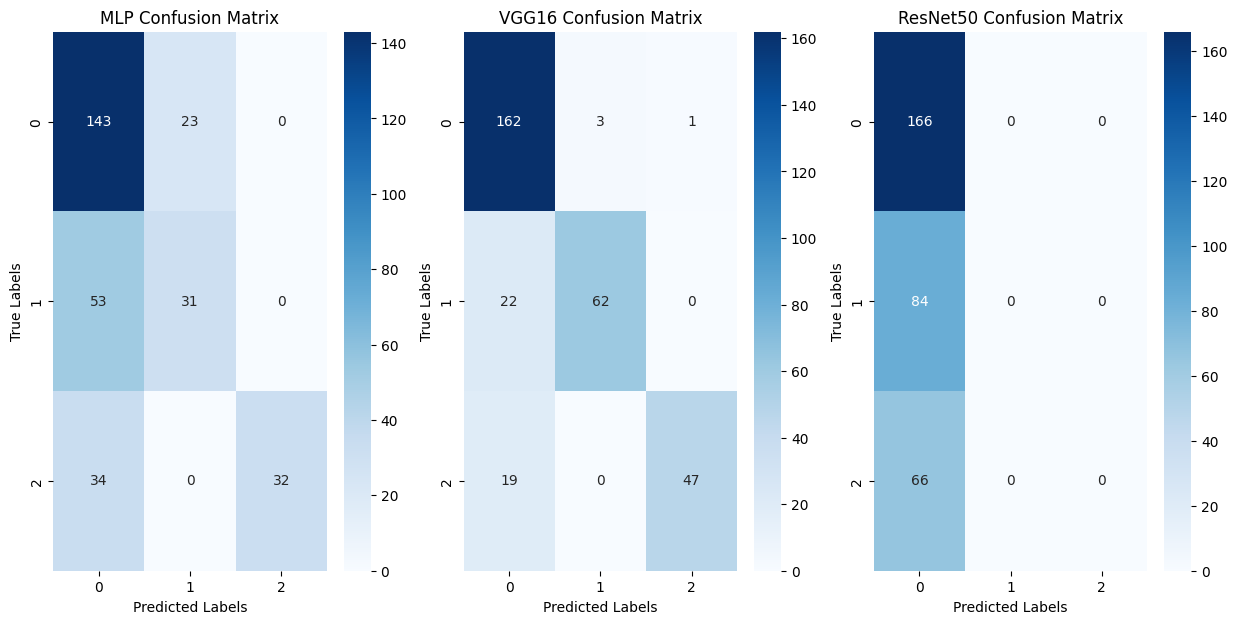

In [15]:
# Cell 14: Display confusion matrices
conf_mat_mlp = confusion_matrix(y_test, y_pred_mlp)
conf_mat_vgg16 = confusion_matrix(y_test, y_pred_vgg16)
conf_mat_resnet50 = confusion_matrix(y_test, y_pred_resnet50)

plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
sns.heatmap(conf_mat_mlp, annot=True, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

plt.subplot(1, 3, 2)
sns.heatmap(conf_mat_vgg16, annot=True, fmt='d', cmap='Blues')
plt.title('VGG16 Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')

plt.subplot(1, 3, 3)
sns.heatmap(conf_mat_resnet50, annot=True, fmt='d', cmap='Blues')
plt.title('ResNet50 Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [16]:
# Cell 15: Display classification reports
print("MLP Classification Report")
print(classification_report(y_test, y_pred_mlp))

print("VGG16 Classification Report")
print(classification_report(y_test, y_pred_vgg16))

print("ResNet50 Classification Report")
print(classification_report(y_test, y_pred_resnet50))


MLP Classification Report
              precision    recall  f1-score   support

           0       0.62      0.86      0.72       166
           1       0.57      0.37      0.45        84
           2       1.00      0.48      0.65        66

    accuracy                           0.65       316
   macro avg       0.73      0.57      0.61       316
weighted avg       0.69      0.65      0.64       316

VGG16 Classification Report
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       166
           1       0.95      0.74      0.83        84
           2       0.98      0.71      0.82        66

    accuracy                           0.86       316
   macro avg       0.91      0.81      0.84       316
weighted avg       0.88      0.86      0.85       316

ResNet50 Classification Report
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       166
           1       0.00      0.00      0.00 

c:\Users\Chimni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chimni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chimni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

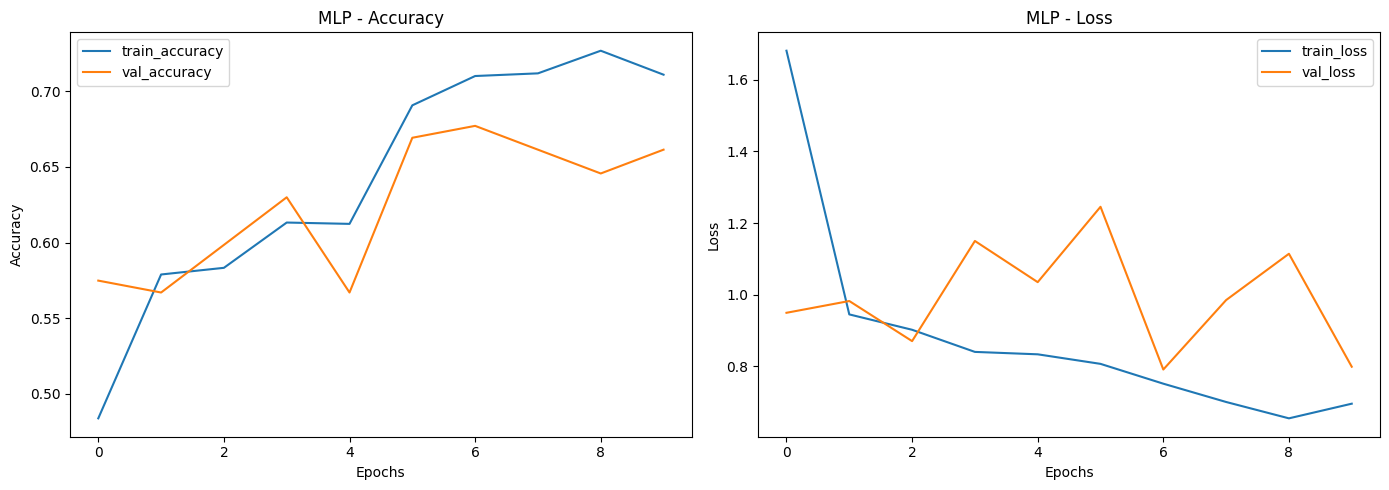

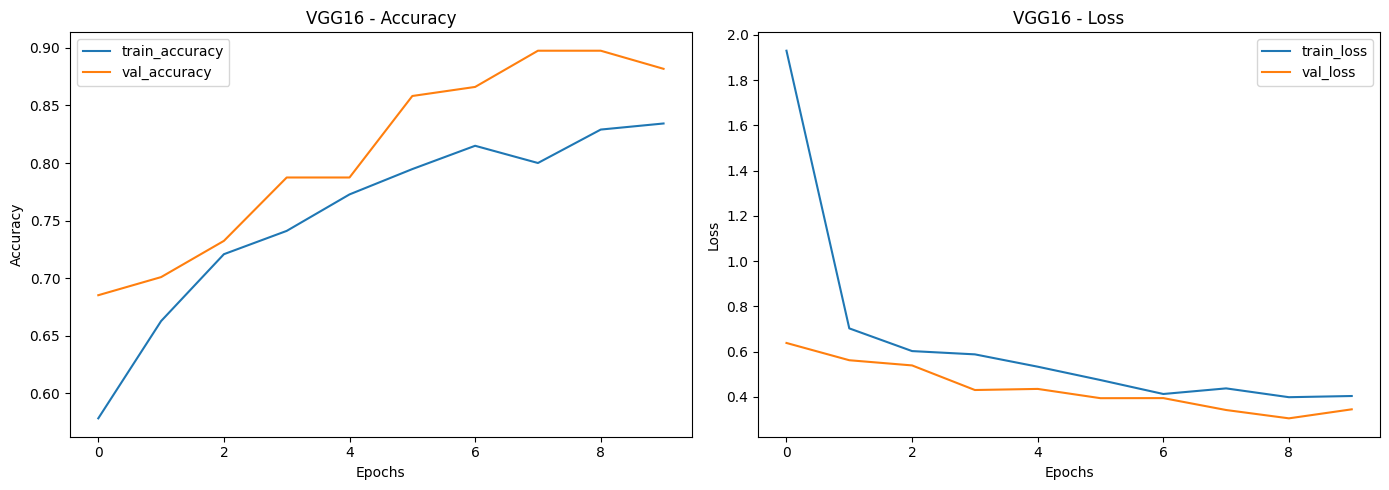

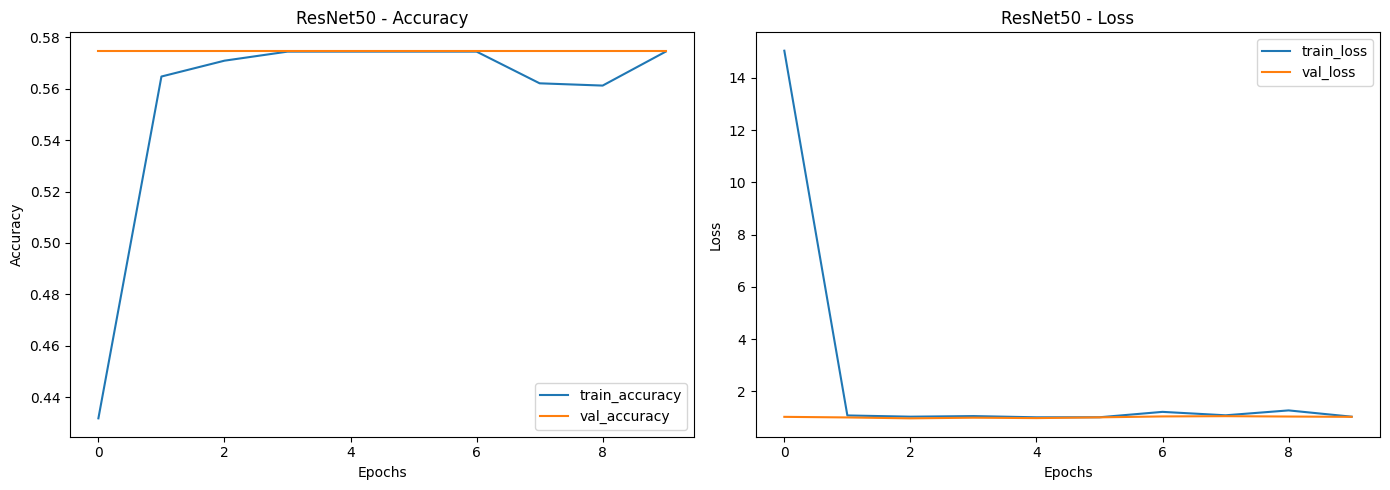

In [17]:
# Cell 16: Plot accuracy and loss curves for each model
def plot_history(history, model_name):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_mlp, "MLP")
plot_history(history_vgg16, "VGG16")
plot_history(history_resnet50, "ResNet50")


In [18]:
model_path = "model.keras"

# Save the VGG16 model
try:
    vgg16_model.save(model_path, save_format='keras')
    print(f"VGG16 model saved successfully at: {model_path}")
except Exception as e:
    print(f"Error while saving the VGG16 model: {e}")

VGG16 model saved successfully at: model.keras
